# Training

In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import time
import pickle

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from scipy.ndimage.measurements import label
from collections import deque

%matplotlib inline

# paths
ROOT_PATH = Path('/home/downloads/carnd-p5-vehicle-detection')

## Utilities

In [2]:
def read_image(img_path):
    if img_path.endswith('.png'):
        img = plt.imread(img_path)*255
        img = np.clip(img, 0, 255).astype(np.uint8)
    else:
        img = plt.imread(img_path)
    
    return img

def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    return features

def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def convert_color_rgb(image, cspace='RGB'):
    if cspace != 'RGB':
        if cspace == 'HSV':
            cvt_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            cvt_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            cvt_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            cvt_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            cvt_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        elif cspace == 'LAB':
            cvt_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    else:
        cvt_image = np.copy(image)
    
    return cvt_image

def extract_hog_features(img, orient, pix_per_cell, cell_per_block, feature_vec=True):
    hog_features = hog(img, orientations=orient, 
                pixels_per_cell=(pix_per_cell, pix_per_cell),
                cells_per_block=(cell_per_block, cell_per_block),
                visualize=False, feature_vector=feature_vec, block_norm='L2-Hys')
    return hog_features

def extract_features(image, cspace='RGB', orient=9, pix_per_cell=8, 
                     spatial_size=(32, 32), hist_bins=32,
                     cell_per_block=2, hog_channel=0, spatial_feat=True,
                     hist_feat=True, hog_feat=True):
    feature_image = convert_color_rgb(image, cspace)
    
    img_features = []
    if spatial_feat:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)

    if hist_feat:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)
    
    if hog_feat:
        if hog_channel == 'ALL':
            hog_features = []
            for ch in range(feature_image.shape[2]):
                hog_features_ch = extract_hog_features(image[:, :, ch], orient, pix_per_cell, cell_per_block, feature_vec=True)
                hog_features.append(hog_features_ch)
            hog_features = np.ravel(hog_features)

        else:
            hog_features = extract_hog_features(feature_image[:, :, hog_channel], orient,
                                                pix_per_cell, cell_per_block, feature_vec=True)
        img_features.append(hog_features)
        
    return np.concatenate(img_features)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

## Training a classifier

In [3]:
cspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 10
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size=(16, 16)
hist_bins = 16
spatial_feat = True
hist_feat = True
hog_feat = True

In [4]:
#CAR_IMAGES_PATH = ROOT_PATH/'data/vehicles/KITTI_extracted'
CAR_IMAGES_PATH = ROOT_PATH/'data/vehicles/all'

NOTCAR_IMAGES_PATH = ROOT_PATH/'data/non-vehicles/GTI'
NOTCAR_IMAGES2_PATH = ROOT_PATH/'data/non-vehicles/Extras'

print('Total car images: ', len(list(CAR_IMAGES_PATH.iterdir())))
print('Not car images: ', len(list(NOTCAR_IMAGES_PATH.iterdir())))
print('Not car images: ', len(list(NOTCAR_IMAGES2_PATH.iterdir())))

Total car images:  6920
Not car images:  3902
Not car images:  5069


car features...


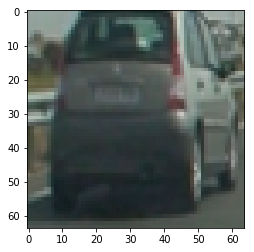

notcar features...


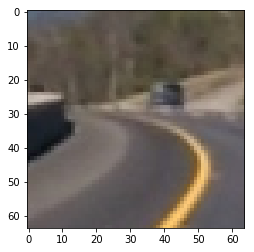

CPU times: user 47.5 s, sys: 704 ms, total: 48.2 s
Wall time: 47.8 s


In [5]:
%%time
SAMPLE_RATIO = 1

car_features = []
# car_files = (list(CAR_IMAGES_PATH.glob('*png')) + 
#              list(CAR_IMAGES2_PATH.glob('*png')) + 
#              list(CAR_IMAGES3_PATH.glob('*png')) +
#              list(CAR_IMAGES4_PATH.glob('*png')) +
#              list(CAR_IMAGES5_PATH.glob('*png')))

print('car features...')
car_files = list(CAR_IMAGES_PATH.glob('*png'))
num_files = len(car_files)
idx = np.random.choice(range(num_files), int(num_files*SAMPLE_RATIO))
for file in np.array(car_files)[idx]:
    img = read_image(file.as_posix())
    features =  extract_features(img, cspace=cspace, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    car_features.append(features)
plt.imshow(img)
plt.show()

print('notcar features...')
notcar_features = []
noncar_files = list(NOTCAR_IMAGES_PATH.glob('*png')) + list(NOTCAR_IMAGES2_PATH.glob('*png'))
num_files = len(noncar_files)
idx = np.random.choice(range(num_files), int(num_files*SAMPLE_RATIO))
for file in np.array(noncar_files)[idx]:
    img = read_image(file.as_posix())
    features =  extract_features(img, cspace=cspace, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features.append(features)
plt.imshow(img)
plt.show()

In [6]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)
print('Shape of X: ', X.shape)

Shape of X:  (15888, 1896)


In [7]:
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
print('Shape of y: ', y.shape)

Shape of y:  (15888,)


Random split

In [8]:
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

In [9]:
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

Training

In [10]:
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC(C=0.01)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 3000
#print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
#print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using: 10 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1896
4.47 Seconds to train SVC...
Test Accuracy of SVC =  0.995
5e-05 Seconds to predict 3000 labels with SVC


In [11]:
MODEL_PATH = ROOT_PATH/'models/svc.pkl'

model = {
    'svc': svc,
    'scaler': X_scaler
}

with open(MODEL_PATH, 'wb') as f:
    pickle.dump(model, f)

In [32]:
model = pickle.load(open(ROOT_PATH/'models/model.pkl', 'rb'))

X_scaler = model['scaler']
svc = model['svc']